# Детекция объектов VOC2012 (Faster RCNN)

## Импорт библиотек

In [2]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

import cv2
import squarify
import matplotlib.pyplot as plt
%matplotlib inline

# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)), в котором присутствует 20 классов изображений.

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [3]:
# Путь до папки с датасетом
DATASET_PATH = "/kaggle/working/VOCdevkit/VOC2012"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# Функция для парсинга xml-файлов
def xml_to_csv(path=ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [4]:
xml_df = xml_to_csv()
print('Successfully converted xml to csv.')

100%|██████████| 3503/3503 [00:00<00:00, 9967.17it/s] 


Successfully converted xml to csv.


In [5]:
xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax
0,2010_006974.jpg,375,500,person,273,215,332,304
1,2010_001023.jpg,500,375,dog,57,47,404,375
2,2010_001852.jpg,500,334,horse,297,26,500,323
3,2010_001852.jpg,500,334,horse,1,1,215,259
4,2010_004631.jpg,500,375,dog,143,23,341,374


In [6]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 7760
Количество изображений в датафрэйме 3503


## Обработка данных

Закодируем классы обьектов.

In [7]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,class
0,2010_006974.jpg,375,500,person,273,215,332,304,14
1,2010_001023.jpg,500,375,dog,57,47,404,375,11
2,2010_001852.jpg,500,334,horse,297,26,500,323,12
3,2010_001852.jpg,500,334,horse,1,1,215,259,12
4,2010_004631.jpg,500,375,dog,143,23,341,374,11


In [8]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
labels_dict = dict(zip(mapping.values(), mapping.keys()))
labels_dict

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

## Формируем датасет

Разделим выборку на train и val.

In [19]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
valid_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Число изображений: {len(image_ids)}')
print(f'Объем train выборки: {len(train_ids)}')
print(f'Объем valid выборки: {len(valid_ids)}')

Число изображений: 3503
Объем train выборки: 2802
Объем valid выборки: 701


In [20]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
train_df.to_csv('train_df.csv', index=None)
valid_df = xml_df[xml_df['filename'].isin(valid_ids)]
valid_df.to_csv('valid_df.csv', index=None)

А что там с балансом классов?

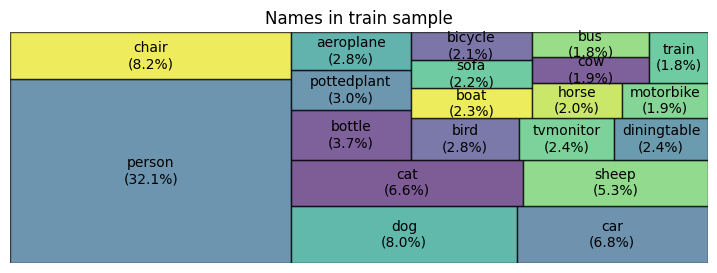

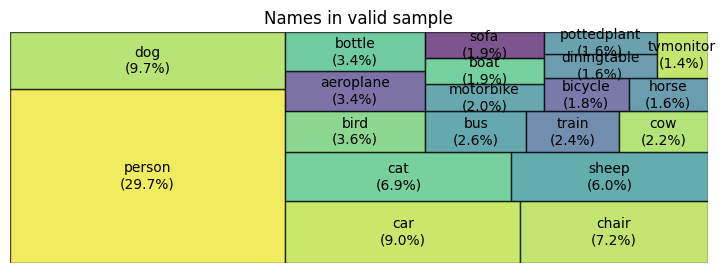

In [21]:
# Получаем распределение значений столбца 'name' с нормализацией
train_names_vls_cnts = train_df['name'].value_counts(normalize=True)
valid_names_vls_cnts = valid_df['name'].value_counts(normalize=True)

# Функция для получения иерархической диаграммы
def get_hierarchical_diagram(vls_cnts, sample='train'):
    plt.figure(figsize=(9, 3))
    squarify.plot(
        sizes=vls_cnts,
        label=[f'{label}\n({value:.1%})' for label, value in zip(
            vls_cnts.index, vls_cnts
            )],
        alpha=0.7, edgecolor='black')
    plt.axis('off')  
    plt.title(f'Names in {sample} sample')
    plt.show()
    
for vls_cnts, sample_name in [(train_names_vls_cnts, 'train'), (valid_names_vls_cnts, 'valid')]:
    get_hierarchical_diagram(vls_cnts, sample=sample_name)

Выборки по составу отличаются не очень сильно, однако налицо сильный дисбаланс классов.

Идем дальше. Пропишем функцию для аугментации:

In [22]:
# Функция для аугментации данных
def get_transforms(phase):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            A.Flip(p=0.5),
            ])
    list_transforms.extend([ToTensorV2(),])
    list_trms = A.Compose(
        list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']}
    )

    return list_trms

Напишем класс `VOC_2010()` для загрузки данных в модель.

In [23]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(
            tuple(map(torch.tensor, zip(*sample['bboxes'])))
        ).permute(1, 0)

        return image, target, image_id


In [24]:
train_data = VOC_2010(train_df, IMAGES_PATH, phase='train')
valid_data = VOC_2010(valid_df, IMAGES_PATH, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(valid_data)}')

Размер обучающей выборки 2802
Размер валидационной выборки 701


In [25]:
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Визуализация данных

In [26]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    plt.figure(figsize=(10, 8))
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes']
    BOX_COLOR = (0, 255, 0)

    for j, box in enumerate(bbox):
        class_name = labels_dict[img[1]['labels'][j].item()]
        cv2.rectangle(
            image, (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            BOX_COLOR, thickness=1
            )
        ((text_width, text_height), _) = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        cv2.rectangle(
            image, (int(box[0]), int(box[1]) - int(1.3 * text_height)),
            (int(box[0]) + text_width, int(box[1])), BOX_COLOR, -1
            )
        cv2.putText(
            image,
            text=class_name,
            org=(int(box[0]), int(box[1]) - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35,
            color=(255, 255, 255),
            lineType=cv2.LINE_AA,
        )
    plt.imshow(image)
    plt.show()

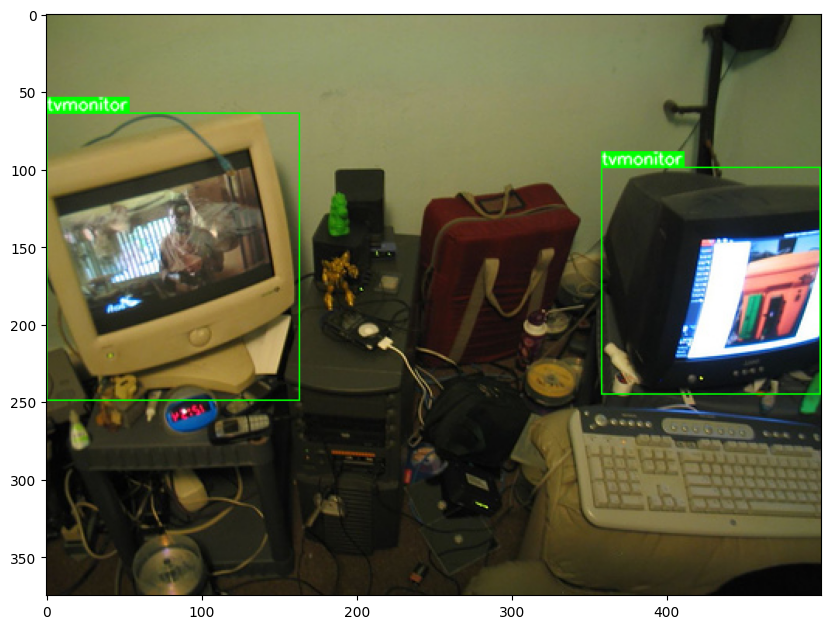

In [59]:
# Выберем рандомный индекс и выведем
# преобразованное изображение из датасета
random_image_idx = np.random.choice(range(len(train_data)))
plot_img(train_data, random_image_idx)

## Загрузка модели

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


Загружаем предобученную модель.

In [61]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 87.1MB/s] 


In [62]:
num_classes = len(np.unique(xml_df['class']))
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

print(model.roi_heads)
# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads)

Число классов: 20
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=20, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=80, bias=True)
  )
)


In [63]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.Внутри функций мы переводим все данные внутри бача на устройство, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную `running_loss` для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [64]:
def train(train_dataloader, rep_freq=10):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        losses.backward()
        optimizer.step()
        if i % rep_freq == 0:
            print(f"\tИтерация #{i} losses: {losses}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(valid_dataloader):
    running_loss = 0
    for data in valid_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    val_loss = running_loss/len(valid_dataloader.dataset)
    return val_loss

## Обучение

Начинаем обучение. Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [65]:
NUM_EPOCHS = 10
REP_FREQ = 100

train_losses = []
val_losses = []
try:
    for epoch in range(NUM_EPOCHS):
        start = time()
        train_loss = train(train_data_loader, rep_freq=REP_FREQ)
        val_loss = val(valid_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch + 1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch + 1} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 losses: 3.6187199706110817
	Итерация #100 losses: 0.6882312093573768
	Итерация #200 losses: 0.23268021459842617
	Итерация #300 losses: 0.39118464399267144
	Итерация #400 losses: 0.7028525911726166
	Итерация #500 losses: 0.4343712557347835
	Итерация #600 losses: 0.7646455757597863
	Итерация #700 losses: 0.5626126811846774
Эпоха #1 train_loss: 0.11707751387435095, val_loss: 0.09292263308837066
Потрачено 9.5 минут на 1 эпоху
	Итерация #0 losses: 0.23494269609203158
	Итерация #100 losses: 0.5550213960617596
	Итерация #200 losses: 0.20017388998775287
	Итерация #300 losses: 0.338586824117879
	Итерация #400 losses: 0.5904794322658722
	Итерация #500 losses: 0.4112575102722322
	Итерация #600 losses: 0.6360695143821006
	Итерация #700 losses: 0.5230853802061104
Эпоха #2 train_loss: 0.09831370567397751, val_loss: 0.0949537993757039
Потрачено 9.5 минут на 2 эпоху
	Итерация #0 losses: 0.22424098585301996
	Итерация #100 losses: 0.5798037473756549
	Итерация #200 losses: 0.1762538276521999

Визуализируем динамику лоссов

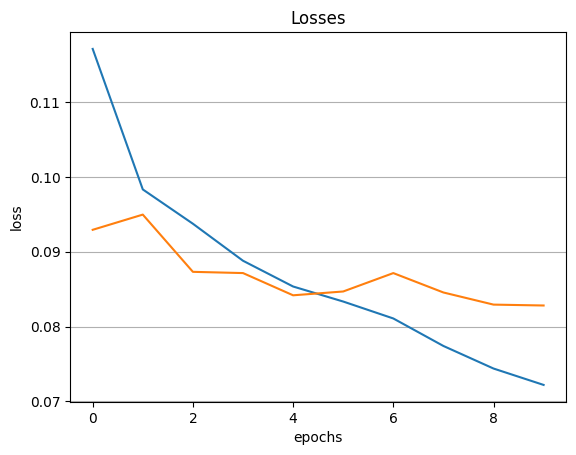

In [66]:
plt.title('Losses')
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(axis='y')
plt.show()

## Предсказание

Напишем функцию для получения предсказаний по интересующей нас выборке

In [67]:
def eval_fn(data_loader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)
        
            for i in range(len(images)):
                boxes = output[i]['boxes'].detach().cpu().numpy()
                labels = output[i]['labels'].detach().cpu().numpy()
                scores = output[i]['scores'].detach().cpu().numpy()

                all_predictions.append({
                    'pred_boxes': (boxes).astype(int),
                    'labels': (labels).astype(int),
                    'scores': scores,
                    'true_boxes': (targets[i]['boxes'].cpu().numpy()).astype(int),
                    'true_labels': (targets[i]['labels'].cpu().numpy()).astype(int),
                    'image_id': image_ids[i]
                })

    return all_predictions

In [68]:
all_predictions = eval_fn(valid_data_loader, model, device)

100%|██████████| 176/176 [00:55<00:00,  3.15it/s]


Соберем из предсказаний таблицу. 

In [69]:
preds_rows = []
for entry in all_predictions:
    for i in range(len(entry['pred_boxes'])):
        preds_rows.append(
            [entry['pred_boxes'][i][0],
             entry['pred_boxes'][i][1],
             entry['pred_boxes'][i][2],
             entry['pred_boxes'][i][3],
             entry['labels'][i],
             labels_dict[entry['labels'][i]],
             entry['scores'][i],
             entry['image_id'] + '.jpg']
             )

preds_df = pd.DataFrame(
    preds_rows,
    columns=[
        'xmin', 'ymin', 'xmax', 'ymax',
        'class', 'name', 'scores', 'filename'
    ]
)

preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,112,126,219,424,14,person,0.987175,2010_006902.jpg
1,49,165,122,358,14,person,0.981316,2010_006902.jpg
2,316,134,335,213,14,person,0.919549,2010_006902.jpg
3,18,136,66,249,14,person,0.914572,2010_006902.jpg
4,252,137,291,231,14,person,0.903094,2010_006902.jpg


In [70]:
#Сохраняем полученные предсказания
preds_df.to_csv('preds_df.csv', index=False)

In [71]:
preds_df = pd.read_csv('preds_df.csv')

preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,112,126,219,424,14,person,0.987175,2010_006902.jpg
1,49,165,122,358,14,person,0.981316,2010_006902.jpg
2,316,134,335,213,14,person,0.919548,2010_006902.jpg
3,18,136,66,249,14,person,0.914572,2010_006902.jpg
4,252,137,291,231,14,person,0.903095,2010_006902.jpg


Посмотрим, насколько предсказания охватывают состав валидационной выборки.

In [8]:
set1 = set(list(preds_df.filename.values))
set2 = set(list(valid_df.filename.values))
intersection = set1.intersection(set2)
union_set = set1 | set2

print(len(intersection) / len(union_set))
print(preds_df.filename.nunique(), valid_df.filename.nunique())

1.0
701 701


## Визуализация предсказаний

In [3]:
# Функция для рассчета площади пересечения двух прямоугольников
def calculate_iou(box1, box2):
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou


def draw_predict(filename, iou_threshold=0.5, score_threshold=0.15):
    for i in range(len(valid_data)):
        if valid_data[i][-1] == filename.split('.')[0]:
            img = image_convert(valid_data[i][0])
    
    preds = preds_df[preds_df['filename'].isin([filename])]
    true = valid_df[valid_df['filename'].isin([filename])]
        
    for j in range(len(preds)):
        for k in range(len(true)):
            pred_box = preds.iloc[j][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            true_box = true.iloc[k][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            iou = calculate_iou(pred_box, true_box)
            score = preds['scores'].values[j]
            if (iou > iou_threshold) and (score > score_threshold):
                label = preds['name'].values[j]
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin']),
                    (pred_box['xmax'], pred_box['ymax']),
                    (255, 0, 0), thickness=1
                )
                ((text_width, text_height), _) = cv2.getTextSize(
                    f"{label} {score:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
                )
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin'] - 3 - int(1.3 * text_height)),
                    (pred_box['xmin'] + text_width, pred_box['ymin']), (255, 0, 0), -1
                )
                cv2.putText(img,
                    text=f"{label} {score:.2f}",
                    org=(pred_box['xmin'], pred_box['ymin'] - 3),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.35,
                    color=(255, 255, 255),
                    lineType=cv2.LINE_AA,
                )
                
    plt.figure(figsize=(10, 8))
    plt.imshow(img)

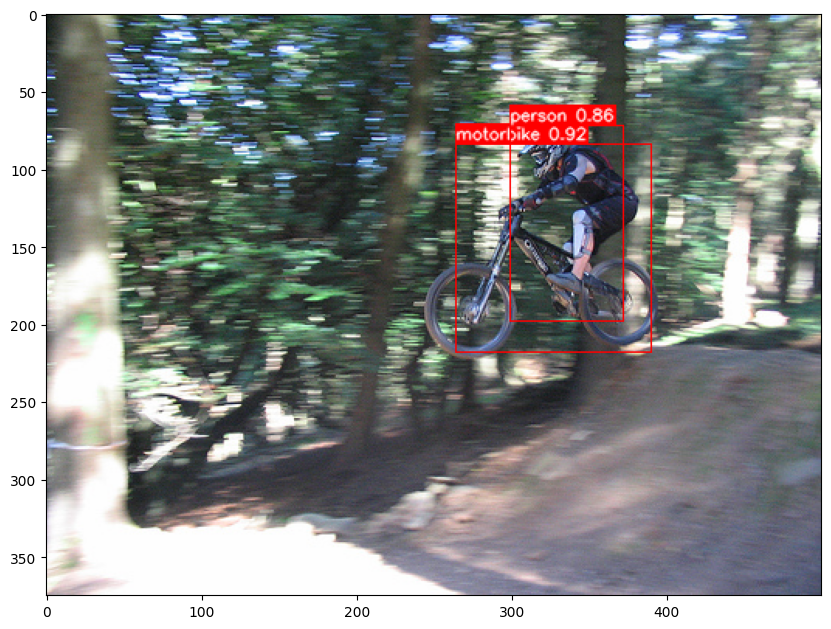

In [75]:
random_image_name = np.random.choice(list(preds_df.filename.unique()))
draw_predict(random_image_name, iou_threshold=0.5, score_threshold=0.5)

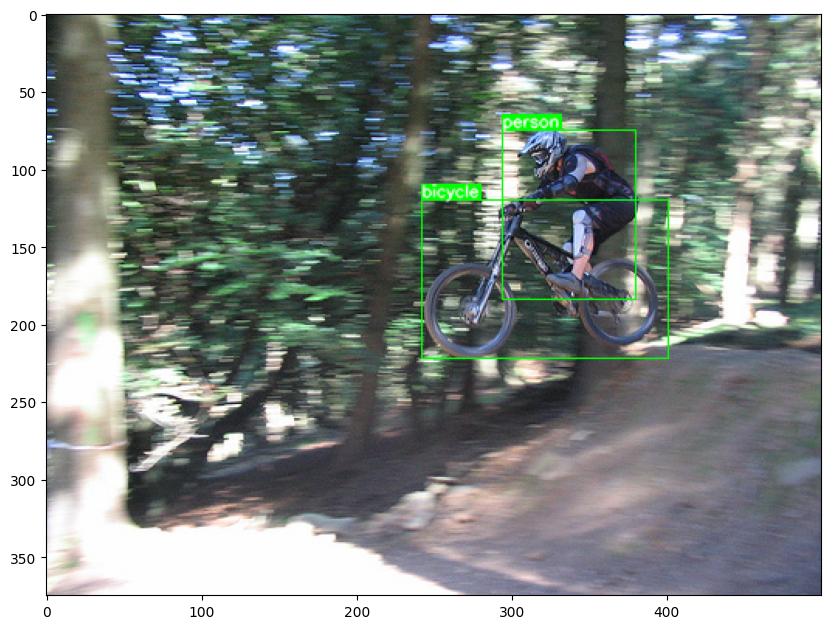

In [76]:
for i in range(len(valid_data)):
    if valid_data[i][-1] == random_image_name.split('.')[0]:
        plot_img(valid_data, i)

## Считаем accuracy

Напишем функцию, которая будет итерироваться по изображениям рассматриаемой нами выборки и для каждого фото выбирать строки из обеих таблиц (из таблицы истинных box-ов и таблицы предсказанных). Далее, для каждого истинного box-а будет производится поиск пары по заданному IoU, и если найдется такой предсказанный box, произойдет сравнение предсказанного класса с истинным. Если класс совпадет хотя бы раз для всех предсказанных box-ов, то счетчик обнаружения объекта += 1. Accuracy в итоге считается как отношения значения счетчика detected к общему числу реальных объектов на фотографиях.

In [6]:
def calculate_detection_accuracy(
    true_df=valid_df, preds=preds_df,
    iou_threshold=0.5, confidence_threshold=0.25,
    get_report=False
    ):
    total_objects = len(true_df)
    correct_objects = 0
    true_val_cnts_dct = dict(true_df.name.value_counts())
    pred_val_cnts_dct = {key: 0 for key in list(true_val_cnts_dct.keys())}
    
    for filename in list(true_df.filename.unique()):
        true_boxes = true_df[true_df['filename'] == filename]
        pred_boxes = preds[preds['filename'] == filename]
        
        for _, true_row in true_boxes.iterrows():
            detected = [0]
            valid_box = {
                'xmin': true_row['xmin'],
                'ymin': true_row['ymin'],
                'xmax': true_row['xmax'],
                'ymax': true_row['ymax']
            }
            true_class = true_row['name']
            for _, pred_row in pred_boxes.iterrows():
                confidence = pred_row['scores']
                if confidence >= confidence_threshold:
                    pred_box = {
                        'xmin': pred_row['xmin'],
                        'ymin': pred_row['ymin'],
                        'xmax': pred_row['xmax'],
                        'ymax': pred_row['ymax']
                    }
                    pred_class = pred_row['name']
                    
                    iou = calculate_iou(pred_box, valid_box)
                    if iou >= iou_threshold:
                        if pred_class == true_class:
                            detected.append(1)
            
            correct_objects += max(detected)
            pred_val_cnts_dct[true_class] += max(detected)
                    
    accuracy = correct_objects / total_objects
    if get_report:
        print('Class name: |  Acc:  |true:|pred:|')
        print('-'*34)
        for k, v in true_val_cnts_dct.items():
            detected_cnt = pred_val_cnts_dct[k]
            print(
                f'{k}'.ljust(11), f'| {detected_cnt/v:.4f} | {v}'.ljust(14),
                f'| {detected_cnt}'.ljust(5), '|')
        print('-'*34)
        print(f'Total Accuracy: {accuracy:.4f}')
    else:
        return accuracy

Можем построить поверхность accuracy при различных значениях IoU и уверенности модели.

In [31]:
iou_thresholds = np.arange(0, 1.1, 0.1)
confidence_thresholds = np.arange(0, 1.1, 0.1)
params_with_accuracy_lst = []

for i in tqdm(range(len(iou_thresholds))):
    
    for j in range(len(confidence_thresholds)):
        acc = calculate_detection_accuracy(
            true_df=valid_df, preds=preds_df,
            iou_threshold=iou_thresholds[i],
            confidence_threshold=confidence_thresholds[j]
            )
        
        params_with_accuracy_lst.append([
            iou_thresholds[i], confidence_thresholds[j], acc
            ])

iou, confidence, accuracy = [], [], []

# Разбиваем список списков на три списка
for sublist in params_with_accuracy_lst:
    iou.append(sublist[0])
    confidence.append(sublist[1])
    accuracy.append(sublist[2])

100%|██████████| 11/11 [03:09<00:00, 17.23s/it]


In [37]:
import plotly.express as px

df = pd.DataFrame(
    data=params_with_accuracy_lst,
    columns=['IoU', 'Confidence', 'Accuracy']
)
fig = px.scatter_3d(
    df, x='IoU', 
    y='Confidence',
    z='Accuracy')
fig.show()

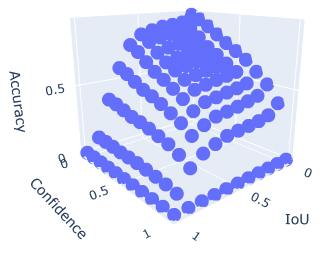

Наибольшее значени метрики, очевидно, достигается при нулевых параметрах: мы не отсеиваем предсказания с малой уверенностью и нам безразлично — пересекаются ли рамки объектов. Любые другие значения параметров налагают соответствующие ограничения. Требуемыми можно счесть значение confidence от 0.25, IoU — от 0.5 (хорошим считается 0.7).

In [7]:
iou, conf = 0.5, 0.0
print(f'Report for IoU: {iou}; Confidence: {conf}')
calculate_detection_accuracy(
    valid_df, preds_df,
    iou_threshold=iou,
    confidence_threshold=conf,
    get_report=True
)

Report for IoU: 0.5; Confidence: 0.0
Class name: |  Acc:  |true:|pred:|
----------------------------------
person      | 0.8826 | 460 | 406 |
dog         | 0.9265 | 136 | 126 |
chair       | 0.6589 | 129 | 85  |
cat         | 0.9314 | 102 | 95  |
sheep       | 0.6804 | 97  | 66  |
car         | 0.8111 | 90  | 73  |
boat        | 0.6271 | 59  | 37  |
aeroplane   | 0.0000 | 46  | 0   |
bottle      | 0.7045 | 44  | 31  |
bus         | 0.9000 | 40  | 36  |
bird        | 0.7027 | 37  | 26  |
train       | 0.7429 | 35  | 26  |
sofa        | 0.7714 | 35  | 27  |
bicycle     | 0.9677 | 31  | 30  |
pottedplant | 0.7333 | 30  | 22  |
motorbike   | 0.9000 | 30  | 27  |
tvmonitor   | 0.7037 | 27  | 19  |
diningtable | 0.7407 | 27  | 20  |
horse       | 0.7407 | 27  | 20  |
cow         | 0.8846 | 26  | 23  |
----------------------------------
Total Accuracy: 0.7924


Если мы перестанем учитывать уровень уверенности модели в классе детектированного объекта, то получим неплохой accuracy при сохранении требования по перекрытию ограничивающих рамок на приемлемом уровне.